# **Importing Libraries**

In [4]:
import torch
import torch.nn as  nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# **Data**

In [5]:
train_dataset  = torchvision.datasets.FashionMNIST(root = '.',
                                                  train = True,
                                                  transform = transforms.ToTensor(),
                                                  download = True)


test_dataset = torchvision.datasets.FashionMNIST(root = '.',
                                                train = False,
                                                transform = transforms.ToTensor(),
                                                download = True)




100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 192kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.3MB/s]


In [6]:
print(train_dataset.data.max())
print(train_dataset.data.shape)
print(train_dataset.targets)

tensor(255, dtype=torch.uint8)
torch.Size([60000, 28, 28])
tensor([9, 0, 0,  ..., 3, 0, 5])


In [7]:
print(test_dataset.data.max())
print(test_dataset.data.shape)
print(test_dataset.targets)


tensor(255, dtype=torch.uint8)
torch.Size([10000, 28, 28])
tensor([9, 2, 1,  ..., 8, 1, 5])


In [8]:
k = len(set(train_dataset.targets.numpy()))
print(f'number of classes:{k}')

number of classes:10


In [9]:
class CNN(nn.Module):
  def __init__(self,k):
    super(CNN,self).__init__()
    self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1,
                                             out_channels =32,
                                             kernel_size = 3,
                                             stride = 2),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels = 32,
                                             out_channels = 64,
                                             kernel_size = 3,
                                             stride = 2),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels = 64,
                                             out_channels = 128,
                                             kernel_size = 3,
                                             stride= 2))
    self.dense_layers = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(128*2*2,512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512,k))
  def forward(self,X):
    out = self.conv_layers(X)
    out = out.view(out.size(0),-1)
    out = self.dense_layers(out)
    return out


In [10]:
model = CNN(k)

In [ ]:
# we can do the same thing without even using class

# model = nn.Sequential(
#     nn.Conv2d(in_channels = 1,
#               out_channels = 32,
#               kernel_size = 3,
#               stride = 2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels  = 32,
#               out_channels = 64,
#               kernerl_size = 3,stride = 2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels = 64,
#               out_channels = 128,
#               kernerl_size = 3,
#               stride = 2),
#     nn.ReLU(),
#     nn.Flatten(128*2*2,512),
#     nn.Dropout(0.2),
#     nn.Linear(128*2*2,512)
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512,k)
# )

In [11]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# **It automatically generate batches in the training loop and take care of shuffling**

In [13]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset= test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

# Lets create a function for training the model

In [14]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for i in range(epochs):
        # -------- Training --------
        model.train()
        train_loss = []

        for inputs, targets in train_loader:
            # sending data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        # -------- Testing --------
        model.eval()
        test_loss = []

        for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          test_loss.append(loss.item())

        test_loss = np.mean(test_loss)

        # -------- Save losses --------
        train_losses[i] = train_loss
        test_losses[i] = test_loss

        print(f"Epoch {i+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Loss: {test_loss:.4f}")

    return train_losses, test_losses


In [15]:
train_losses,test_losses = batch_gd(model,criterion,optimizer,train_loader,test_loader,epochs = 15)

Epoch 1/15 | Train Loss: 0.6259 | Test Loss: 0.4673
Epoch 2/15 | Train Loss: 0.4197 | Test Loss: 0.4060
Epoch 3/15 | Train Loss: 0.3628 | Test Loss: 0.3596
Epoch 4/15 | Train Loss: 0.3259 | Test Loss: 0.3326
Epoch 5/15 | Train Loss: 0.3009 | Test Loss: 0.3125
Epoch 6/15 | Train Loss: 0.2759 | Test Loss: 0.3071
Epoch 7/15 | Train Loss: 0.2595 | Test Loss: 0.3034
Epoch 8/15 | Train Loss: 0.2409 | Test Loss: 0.2865
Epoch 9/15 | Train Loss: 0.2255 | Test Loss: 0.2982
Epoch 10/15 | Train Loss: 0.2132 | Test Loss: 0.2905
Epoch 11/15 | Train Loss: 0.2018 | Test Loss: 0.2869
Epoch 12/15 | Train Loss: 0.1888 | Test Loss: 0.2919
Epoch 13/15 | Train Loss: 0.1814 | Test Loss: 0.3085
Epoch 14/15 | Train Loss: 0.1711 | Test Loss: 0.3152
Epoch 15/15 | Train Loss: 0.1623 | Test Loss: 0.3011


In [21]:
train_losses

array([0.62592581, 0.41968882, 0.3627886 , 0.32592881, 0.30092944,
       0.2759465 , 0.25950415, 0.24085984, 0.22553275, 0.21324308,
       0.20183089, 0.18881862, 0.18138988, 0.17112659, 0.16228166])

In [22]:
test_losses

array([0.46725292, 0.40595336, 0.35958975, 0.33262083, 0.31251986,
       0.30706728, 0.30338458, 0.28651234, 0.29823569, 0.29045137,
       0.28694716, 0.29191204, 0.30854532, 0.31515198, 0.30105778])

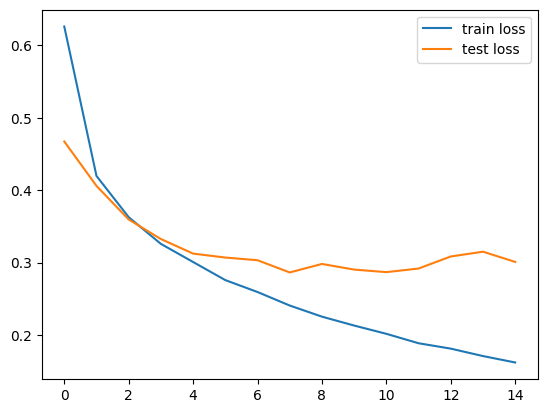

In [23]:
plt.plot(train_losses,label = 'train loss')
plt.plot(test_losses,label = 'test loss')
plt.legend()
plt.show()

# Accuracy

In [24]:
model.eval()
n_correct = 0
n_total = 0
for inputs,targets in train_loader:

  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)


  _,prediction = torch.max(outputs,1)
  #torch.max return both max and argmax

  n_correct += (prediction == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

In [25]:
train_acc

0.9540833333333333

In [26]:
n_correct = 0
n_total = 0
for inputs,targets in test_loader:

  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)

  _,predictions = torch.max(outputs,1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

In [27]:
test_acc

0.9027

# Visualization

In [28]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

import itertools


def plot_Confusion_matrix(cm,classes,normalize = False,title = 'confusion matrix',cmap = plt.cm.Blues):
  if normalize:
    cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
    print('normalized confusion matrix')
  else:
    print('confusion matrix without normalized')

  print(cm)

  plt.imshow(cm,interpolation = 'nearest',cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation = 45)
  plt.yticks(tick_marks,classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2.0
  for i ,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')
  plt.show()


confusion matrix without normalized
[[883   0  20  10   1   1  82   0   3   0]
 [  5 974   1  11   5   0   4   0   0   0]
 [ 18   0 815   6  72   0  88   0   1   0]
 [ 20   7  15 893  45   0  20   0   0   0]
 [  0   1  32  17 853   0  96   0   1   0]
 [  0   0   0   1   0 978   0  12   1   8]
 [117   1  50  12  77   0 735   0   8   0]
 [  0   0   0   0   0  13   0 962   0  25]
 [  3   0   3   1   6   3   8   1 975   0]
 [  0   0   0   0   0   7   0  34   0 959]]


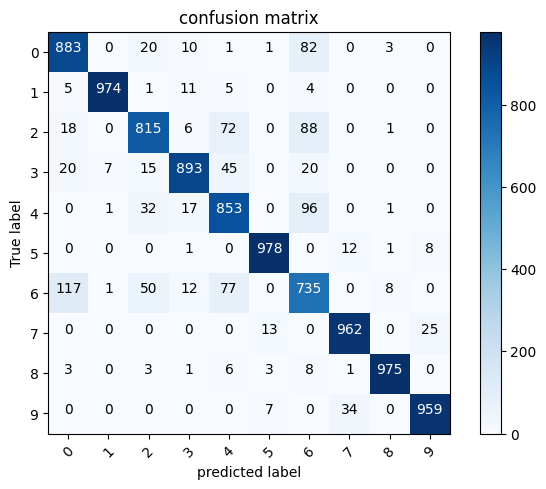

In [29]:
x_test = test_dataset.data.numpy()
y_test= test_dataset.targets.numpy()
p_test = np.array([])

for inputs,targets in test_loader:

  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)

  _,predictions = torch.max(outputs,1)

  p_test = np.concatenate((p_test,predictions.cpu().numpy()))

cm = sk_confusion_matrix(y_test,p_test)
plot_Confusion_matrix(cm,list(range(10)))

# Mapping

In [30]:
labels = '''T-shirt/top
trouser
pullover
dress
coat
sandal
shirt
sneaker
bag
ankle boot'''.split('\n')

# **Show misclassifier images**

Text(0.5, 1.0, 'True label: % predicted %')

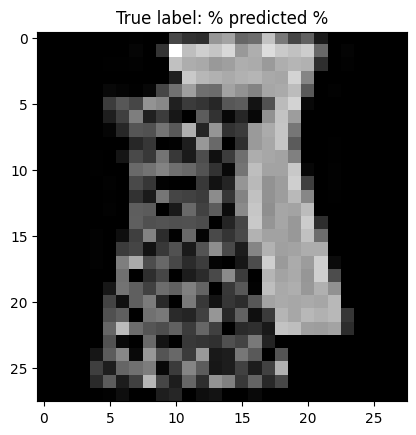

In [37]:
p_test = p_test.astype(np.uint8)
misclassified_idx =  np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28),cmap = 'gray')
plt.title('True label: % predicted %')